In [1]:
import deepinv as dinv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
from tqdm import tqdm

#from PMCPnP import PMCPnP
from utils import get_physics, get_image, get_model

%load_ext autoreload
%autoreload 2

/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
EXPERIMENT_DIRECTORY = Path().cwd() / "experiments"
DATA_DIRECTORY = Path().cwd() / "data"
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"


Selected GPU 0 with 24151 MB free memory 


In [4]:
def run_experiment(image_name, 
                   transformation_name, 
                   model_name, 
                   max_iter=500, 
                   stepsize=0.05, 
                   lambd=0.01, 
                   sigma=0.05,
                   verbose=True):
    
    img_size = 256
    
    image = get_image(DATA_DIRECTORY, name=image_name, img_size=img_size, device=device)
    if transformation_name == 'downsampling':
        factor = 2
    else:
        factor = 10
    physics = get_physics(transformation_name, 
                          img_size, 
                          sigma, 
                          device=device, 
                          factor=factor)
    y = physics(image)
        
    if model_name in ['PnP', 'RED']:
        denoiser = dinv.models.DRUNet(pretrained="download").to(device)
    else:
        denoiser = dinv.models.DiffUNet(large_model=False).to(device)
        
    likelihood = dinv.optim.L2(sigma=sigma)
    
    model = get_model(model_name,
                        denoiser, 
                        likelihood, 
                        max_iter=max_iter,
                        stepsize=stepsize,
                        lambd=lambd,
                        sigma=sigma,
                        device=device)
    
    if model_name in  ["RED", "PnP"]:
        out, metrics = model(y, physics, x_gt=image, compute_metrics=True)
        if verbose: print(dinv.utils.metric.cal_psnr(out, image))
        return out, metrics, image, y
    
    elif model_name == "DPS":
        out = model(y, physics)
        if verbose: print(dinv.utils.metric.cal_psnr(out, image))
        return out, _, image, y
    
    else:
        mean, var = model(y, physics)
        if verbose: print(dinv.utils.metric.cal_psnr(mean, image))
        return mean, var, image, y
    
    

In [5]:
image_names = [
        "face1", 
        "face2", 
        "face3", 
        "bedroom", 
        "butterfly",
               ]
transformation_names = [
        #"compressed_sensing", 
        "inpainting", 
        "downsampling", 
        "blur",
                        ]
model_names = [
        "RED", 
        "PnP", 
        "DPS", 
        "PnP-ULA", 
        "PMCPnP", 
        "PMCReD", 
        "PMCPnPAnnealing", 
        "PMCReDAnnealing",
               ]

import optuna
def objective(trial):
        #max_iter = trial.suggest_int("max_iter", 100, 1000)
        stepsize = trial.suggest_float("stepsize", 0.0005, 0.009)
        
        out, metrics, image, y = run_experiment(
                                "butterfly", 
                                "blur", 
                                "PMCPnPAnnealing", 
                                max_iter=2000, 
                                verbose=False,
                                stepsize=stepsize,
                                lambd=0.01,
                                sigma=0.05,
                        )
        
        return dinv.utils.metric.cal_psnr(out, image)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=6)

print(study.best_params)



[I 2024-03-25 14:09:05,226] A new study created in memory with name: no-name-79096522-226f-43c5-a816-99b219d2d2b9
/Data/jaybee/miniconda3/envs/altegrad/lib/python3.11/site-packages/deepinv/physics/blur.py:264: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  y[i, j, :, :] = F.conv2d(
100%|██████████| 2000/2000 [01:03<00:00, 31.68it/s]
[I 2024-03-25 14:10:12,421] Trial 0 finished with value: 26.686870574951172 and parameters: {'stepsize': 0.0010982773405171509}. Best is trial 0 with value: 26.686870574951172.


Monte Carlo sampling finished! elapsed time=63.15 seconds
Iteration 1999, current converge crit. = 1.10E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:03<00:00, 31.60it/s]
[I 2024-03-25 14:11:16,281] Trial 1 finished with value: 23.87762451171875 and parameters: {'stepsize': 0.005090192697457651}. Best is trial 0 with value: 26.686870574951172.


Monte Carlo sampling finished! elapsed time=63.30 seconds
Iteration 1999, current converge crit. = 3.23E-04, objective = 1.00E-03 
Iteration 1999, current converge crit. = 7.36E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:03<00:00, 31.59it/s]
[I 2024-03-25 14:12:20,178] Trial 2 finished with value: -4.280643463134766 and parameters: {'stepsize': 0.008145285004579842}. Best is trial 0 with value: 26.686870574951172.


Monte Carlo sampling finished! elapsed time=63.33 seconds
Iteration 1999, current converge crit. = 7.44E-05, objective = 1.00E-03 
Iteration 1999, current converge crit. = 3.56E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:02<00:00, 32.24it/s]
[I 2024-03-25 14:13:22,736] Trial 3 finished with value: 15.772130966186523 and parameters: {'stepsize': 0.005828212126672403}. Best is trial 0 with value: 26.686870574951172.


Monte Carlo sampling finished! elapsed time=62.05 seconds
Iteration 1999, current converge crit. = 4.76E-04, objective = 1.00E-03 
Iteration 1999, current converge crit. = 5.10E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:02<00:00, 32.20it/s]
[I 2024-03-25 14:14:25,365] Trial 4 finished with value: -4.291013717651367 and parameters: {'stepsize': 0.008555840908782747}. Best is trial 0 with value: 26.686870574951172.


Monte Carlo sampling finished! elapsed time=62.12 seconds
Iteration 1999, current converge crit. = 6.97E-05, objective = 1.00E-03 
Iteration 1999, current converge crit. = 3.94E-04, objective = 1.00E-03 


100%|██████████| 2000/2000 [01:02<00:00, 32.25it/s]
[I 2024-03-25 14:15:27,896] Trial 5 finished with value: 0.8961317539215088 and parameters: {'stepsize': 0.007172616217770026}. Best is trial 0 with value: 26.686870574951172.


Monte Carlo sampling finished! elapsed time=62.02 seconds
Iteration 1999, current converge crit. = 3.31E-04, objective = 1.00E-03 
Iteration 1999, current converge crit. = 7.05E-04, objective = 1.00E-03 
{'stepsize': 0.0010982773405171509}


14.821008682250977
tensor(-0.0966, device='cuda:0') tensor(1.0201, device='cuda:0')


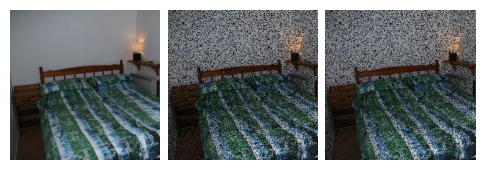

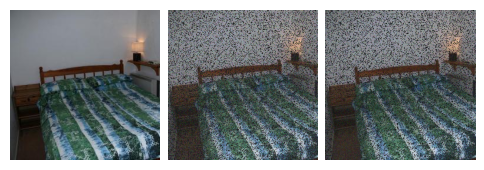

In [332]:
_ = torch.manual_seed(42)
image = "bedroom"
transformation_name = "inpainting"
model_name = "RED"

out, metrics, image, y = run_experiment(
                        image_name=image,
                        transformation_name=transformation_name,
                        model_name=model_name,
                        max_iter=10,
                        stepsize=0.3,
                        lambd=0.01,
                        sigma=0.05
                    ) 
print(out.min(), out.max())
dinv.utils.plotting.plot([image, y, out], rescale_mode='clip')
dinv.utils.plotting.plot([image, y, out], rescale_mode='min_max')

# SIGMA = 0.05

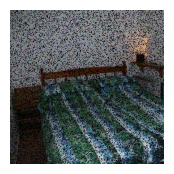

In [334]:

dinv.utils.plotting.plot([out], rescale_mode='clip')



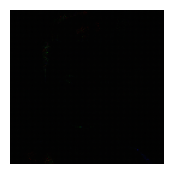

In [321]:
dinv.utils.plotting.plot([metrics], rescale_mode='min_max')

# Evaluate Lipswhitz constant

In [335]:
denoiser = dinv.models.DiffUNet(large_model=False).to(device)

In [436]:


x_1 = 2 * torch.rand(1, 3, 256, 256, requires_grad=True).to(device) - 1
x_2 = 2 * torch.rand(1, 3, 256, 256, requires_grad=True).to(device) - 1
print(x_1.min(), x_1.max())

out_1 = denoiser.forward_denoise(x_1, 0.02)
out_2 = denoiser.forward_denoise(x_2, 0.02)

grad_1 = torch.autograd.grad(outputs=out_1, inputs=x_1, grad_outputs=torch.ones_like(out_1))[0]
grad_2 = torch.autograd.grad(outputs=out_2, inputs=x_2, grad_outputs=torch.ones_like(out_2))[0]


print(torch.linalg.norm(grad_1.flatten() - grad_2.flatten(), ord=2) / torch.linalg.norm(x_2.flatten() - x_1.flatten(), ord=2))

tensor(-1.0000, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8544, device='cuda:0', grad_fn=<DivBackward0>)


In [35]:
import torch
import deepinv as dinv
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

denoiser = dinv.models.DiffUNet(large_model=False).to(device)

# Generate interpolation samples
def generate_interpolated_samples(x1, y1, x2, y2, alpha):
    x = alpha * x1 + (1 - alpha) * x2
    y = alpha * y1 + (1 - alpha) * y2
    return x, y

# Compute Lipschitz constant
def lipschitz_constant(x_1, x_2):    
    out_1 = denoiser.forward_denoise(x_1, 0.02)
    out_2 = denoiser.forward_denoise(x_2, 0.02)

    grad_1 = torch.autograd.grad(outputs=out_1, inputs=x_1, grad_outputs=torch.ones_like(out_1))[0]
    grad_2 = torch.autograd.grad(outputs=out_2, inputs=x_2, grad_outputs=torch.ones_like(out_2))[0]

    lipschitz = torch.norm(grad_1 - grad_2) / torch.norm(x_1 - x_2)
    return lipschitz.item()

Selected GPU 0 with 15067 MB free memory 


In [41]:
x_1 = 2 * torch.rand(1, 3, 256, 256, requires_grad=True).to(device)
x_2 = torch.rand(1, 3, 256, 256, requires_grad=True).to(device)
x_11 = torch.rand(1, 3, 256, 256, requires_grad=True).to(device)
x_22 = torch.rand(1, 3, 256, 256, requires_grad=True).to(device)
x, y = generate_interpolated_samples(x_1, x_2, x_11, x_22, 0.5)
lipschitz_constant(x, x)

inf

# Evaluate NLL

In [47]:
import numpy as np

def nll_loss(true_labels, predicted_means, predicted_variances):
    nll = 0.5 * np.log(2 * np.pi * predicted_variances) + \
          0.5 * np.square((true_labels - predicted_means) / np.sqrt(predicted_variances))
    return np.mean(nll)


from PIL import Image
import numpy as np

method_list = ["PnP-ULA", "PMCPnP", "PMCReD", "PMCPnPAnnealing", "PMCReDAnnealing"]
image_list = ["bedroom", "butterfly", "face"]
transformation_list = ["inpainting", "downsampling", "blur"]

for image in image_list:
    for transformation in transformation_list:
        for method in method_list:

            # Load PNG image using Pillow
            print(f"Processing {image} {transformation} {method}")
            img = np.array(Image.open(f'experiments/{image}_{transformation}_005/base_image.png').convert('RGB'))
            out = np.array(Image.open(f'experiments/{image}_{transformation}_005/{method}_out.png').convert('RGB'))
            var = np.array(Image.open(f'experiments/{image}_{transformation}_005/{method}_var.png').convert('RGB'))


            print(nll_loss(img, out, var))

Processing bedroom inpainting PnP-ULA
1195.102868257448
Processing bedroom inpainting PMCPnP
540.4056081098878
Processing bedroom inpainting PMCReD
380.59309867753285
Processing bedroom inpainting PMCPnPAnnealing
1508.8114669403585
Processing bedroom inpainting PMCReDAnnealing
1310.4952793305708
Processing bedroom downsampling PnP-ULA
1846.3695173805697
Processing bedroom downsampling PMCPnP
348.3126703807456
Processing bedroom downsampling PMCReD
264.9529161364919
Processing bedroom downsampling PMCPnPAnnealing
766.8529635272608
Processing bedroom downsampling PMCReDAnnealing


FileNotFoundError: [Errno 2] No such file or directory: 'experiments/bedroom_downsampling_005/PMCReDAnnealing_out.png'